# 1. YOLO

In [ ]:
from PIL import Image

In [ ]:
!pip install ultralytics

In [ ]:
!git clone https://github.com/Bing-su/adetailer

In [ ]:
%cd /content/adetailer/

/content/adetailer


In [ ]:
from __future__ import annotations

from pathlib import Path
from typing import TYPE_CHECKING

import cv2
from PIL import Image
from torchvision.transforms.functional import to_pil_image

from adetailer import PredictOutput
from adetailer.common import create_mask_from_bbox

if TYPE_CHECKING:
    import torch
    from ultralytics import YOLO, YOLOWorld


def ultralytics_predict(
    model_path: str | Path,
    image: Image.Image,
    confidence: float = 0.3,
    device: str = "",
    classes: str = "",
) -> PredictOutput:
    from ultralytics import YOLO
    model = YOLO(model_path)
    apply_classes(model, model_path, classes)
    pred = model(image, conf=confidence, device=device)

    bboxes = pred[0].boxes.xyxy.cpu().numpy()
    if bboxes.size == 0:
        return PredictOutput()
    bboxes = bboxes.tolist()

    if pred[0].masks is None:
        masks = create_mask_from_bbox(bboxes, image.size)
    else:
        masks = mask_to_pil(pred[0].masks.data, image.size)
    preview = pred[0].plot()
    preview = cv2.cvtColor(preview, cv2.COLOR_BGR2RGB)
    preview = Image.fromarray(preview)
    return masks



def apply_classes(model: YOLO | YOLOWorld, model_path: str | Path, classes: str):
    if not classes or "-world" not in Path(model_path).stem:
        return
    parsed = [c.strip() for c in classes.split(",") if c.strip()]
    if parsed:
        model.set_classes(parsed)


def mask_to_pil(masks: torch.Tensor, shape: tuple[int, int]) -> list[Image.Image]:
    """
    Parameters
    ----------
    masks: torch.Tensor, dtype=torch.float32, shape=(N, H, W).
        The device can be CUDA, but `to_pil_image` takes care of that.

    shape: tuple[int, int]
        (W, H) of the original image
    """
    n = masks.shape[0]
    return [to_pil_image(masks[i], mode="L").resize(shape) for i in range(n)]


In [ ]:
import pytest
from huggingface_hub import hf_hub_download
@pytest.mark.parametrize(
    "model_name",
    [
        "face_yolov8n.pt",
        "face_yolov8n_v2.pt",
        "face_yolov8s.pt",
        "hand_yolov8n.pt",
        "hand_yolov8s.pt",
        "person_yolov8n-seg.pt",
        "person_yolov8s-seg.pt",
        "person_yolov8m-seg.pt",
        "deepfashion2_yolov8s-seg.pt",
    ],
)
def test(sample_image: Image.Image, model_name: str, confidence: float):
    model_path = hf_hub_download("Bingsu/adetailer", model_name)
    result = ultralytics_predict(model_path, sample_image, confidence)
    return result
    # assert result.preview is not None


In [ ]:
image = Image.open("1.png")
image

In [ ]:
res = test(image, "hand_yolov8s.pt", 0.01)


0: 640x480 3 hands, 559.7ms
Speed: 4.7ms preprocess, 559.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)


In [ ]:
res

[<PIL.Image.Image image mode=L size=768x1024>]

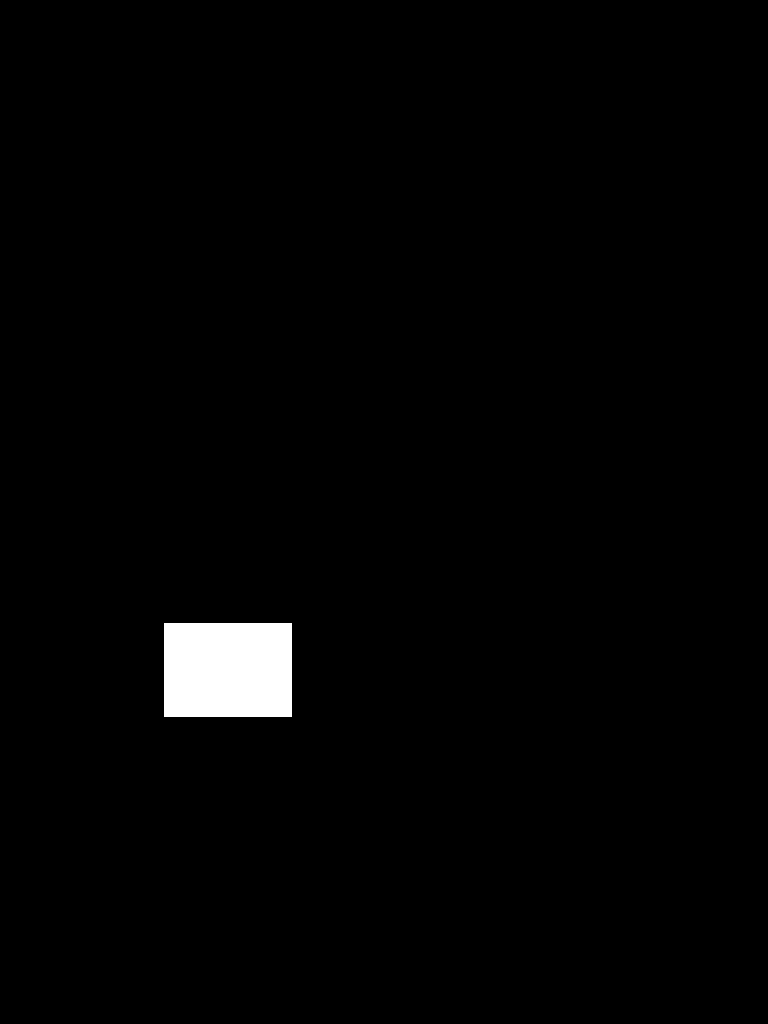

In [ ]:
res[1]

In [ ]:
%cd ..

/content


another way

In [ ]:
! git clone https://github.com/siriusdemon/hand-yolov5

In [ ]:
%cd hand-yolov5
!python setup.py install

In [ ]:
!python demo.py "/content/1.png"

/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Done!


make it unrectangle

In [ ]:
import cv2
import numpy as np
from PIL import Image, ImageDraw

In [ ]:
mask_image_pil = res[1]

In [ ]:
mask_image_pil.save("/content/0.png", "PNG")

In [ ]:
def find_rectangle_coordinates(image_path):
    # Read the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Find contours in the image
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the contour with the largest area (assuming it's the rectangle)
    max_contour = max(contours, key=cv2.contourArea)

    # Get the bounding box coordinates
    x, y, w, h = cv2.boundingRect(max_contour)

    return x, y, w, h

def add_circles_around_rectangle(image_path, num_circles=1000, circle_radius=8):
    # Find rectangle coordinates
    x, y, w, h = find_rectangle_coordinates(image_path)

    # Load the image
    image = Image.open(image_path).convert("RGBA")

    # Create a drawing object
    draw = ImageDraw.Draw(image)

    # Draw the white rectangle
    draw.rectangle([x, y, x + w, y + h], fill=(255, 255, 255, 255))

    # Add circles around the rectangle
    for _ in range(num_circles):
        center_x = np.random.randint(x - circle_radius, x + w + circle_radius)
        center_y = np.random.randint(y - circle_radius, y + h + circle_radius)
        draw.ellipse(
            [
                center_x - circle_radius,
                center_y - circle_radius,
                center_x + circle_radius,
                center_y + circle_radius,
            ],
            fill=(255, 255, 255, 255),
        )
    return image

In [ ]:
result = add_circles_around_rectangle("/content/0.png")

In [ ]:
result

# 2. Palette

In [ ]:
from PIL import Image
from torchvision import transforms

In [ ]:
def get_cond_color(cond_image, mask_size=64):
    H, W = cond_image.size
    cond_image = cond_image.resize((W // mask_size, H // mask_size), Image.BICUBIC)
    color = cond_image.resize((H, W), Image.NEAREST)
    return color

In [ ]:
pil_image = Image.open("4.png")

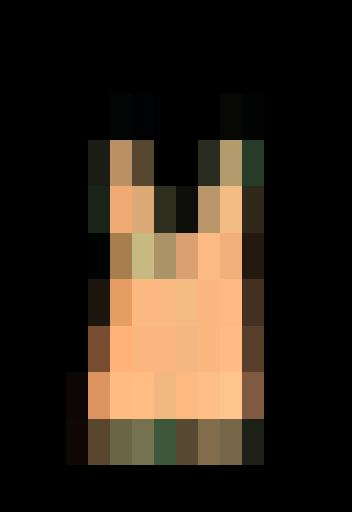

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

palette = get_cond_color(pil_image, mask_size=32)


palette

In [ ]:
palette.size

(768, 1024)